In [39]:
import numpy as np
%load_ext autoreload
%autoreload 2

import datetime
import random
import utils

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
from kneed import KneeLocator
from sklearn.cluster import KMeans

pd.options.display.float_format = '{:.0f}'.format
random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Load data 

Load data either from downloaded CSV or via REST API.

Data loaded from API is slightly different from the data from CSV, so it needs to be aligned to fit the CSV data.

In [49]:

# basic configurations
READ_FROM_API = True

# load data
if READ_FROM_API:
    CRED_FILE = "credentials.json"
    df_json = utils.read_from_web(CRED_FILE)
    
    web_csv_translation = {
        "timestamp": "Timestamp in local format",
        "player_id": "Name",
        "duration": "Duration (s)",
        "metabolic_power_avg": "Metabolic Power (Ø)",
        "mechanical_load": "Skating Load",
        "mechanical_intensity": "Skating Intensity"
    }
    
    df = df_json.rename(columns=web_csv_translation)
    df["Name"] = df["Name"].apply(lambda x: str(x))
    df["Timestamp (ms)"] = pd.to_datetime(df["Timestamp in local format"]).apply(lambda x: x.timestamp() * 1000)
        
else:
    FILE = "data/Events-Match_Test__TEAM_A_vs__TEAM_B-Period_Period_1_Period_Period_2_Period_Period_3.csv"
    EVENT_TYPE = "Shifts"
    
    # load initial dataset
    df = utils.read_file(FILE, EVENT_TYPE)
    

print("Data Frame loaded successfully!")
df


Data Frame loaded successfully!


,Timestamp in local format,timezone_id,game_clock,period,Name,end_time,Duration (s),id,event_type,league_id,...,distance_speed_category3,distance_speed_category4,distance_speed_category5,distance_speed_category6,distance_speed_category7,Metabolic Power (Ø),speed_max,Skating Load,Skating Intensity,Timestamp (ms)
0,2022-12-10 18:46:35,385,,T1,448,1670697984,20,377107,shift,,...,0,0,0,0,None,10,1,0,1,1670697995000
1,2022-12-10 18:46:35,385,,T1,480,1670697984,33,377165,shift,,...,35,20,40,28,None,0,8,21,38,1670697995000
2,2022-12-10 18:46:35,385,,T1,479,1670697984,34,377168,shift,,...,21,30,7,15,None,0,7,26,45,1670697995000
3,2022-12-10 18:46:35,385,,T1,438,1670697984,35,377176,shift,,...,25,36,9,0,None,337,6,22,37,1670697995000
4,2022-12-10 18:46:35,385,,T1,443,1670697984,44,377221,shift,,...,39,51,36,4,None,413,7,29,39,1670697995000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,2022-12-10 20:48:06,385,,T3,478,1670705536,117,393686,shift,,...,33,19,38,32,None,0,9,39,20,1670705286000
707,2022-12-10 20:48:36,385,,T3,479,1670705536,105,393687,shift,,...,16,21,20,41,None,0,8,11,6,1670705316000
708,2022-12-10 20:51:04,385,,T3,482,1670705536,51,393688,shift,,...,18,22,13,0,None,0,7,27,31,1670705464000
709,2022-12-10 20:51:04,385,,T3,483,1670705536,52,393689,shift,,...,33,32,31,42,None,0,8,25,29,1670705464000


# 2. Experiment with Intensities

Try different configurations ond see how to best calculate the intensities of different shifts.

In [50]:
# Generate dataset
df_no_keepers = df[~df["Name"].str.contains("Goalkeeper")]

if not READ_FROM_API:
    # because we have no actual names when reading from api.
    # but we need to separate teams somehow else. Not done yet.
    df_no_keepers = df_no_keepers[df_no_keepers["Name"].str.contains("Guest")]
    
df_no_keepers

,Timestamp in local format,timezone_id,game_clock,period,Name,end_time,Duration (s),id,event_type,league_id,...,distance_speed_category3,distance_speed_category4,distance_speed_category5,distance_speed_category6,distance_speed_category7,Metabolic Power (Ø),speed_max,Skating Load,Skating Intensity,Timestamp (ms)
0,2022-12-10 18:46:35,385,,T1,448,1670697984,20,377107,shift,,...,0,0,0,0,None,10,1,0,1,1670697995000
1,2022-12-10 18:46:35,385,,T1,480,1670697984,33,377165,shift,,...,35,20,40,28,None,0,8,21,38,1670697995000
2,2022-12-10 18:46:35,385,,T1,479,1670697984,34,377168,shift,,...,21,30,7,15,None,0,7,26,45,1670697995000
3,2022-12-10 18:46:35,385,,T1,438,1670697984,35,377176,shift,,...,25,36,9,0,None,337,6,22,37,1670697995000
4,2022-12-10 18:46:35,385,,T1,443,1670697984,44,377221,shift,,...,39,51,36,4,None,413,7,29,39,1670697995000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,2022-12-10 20:48:06,385,,T3,478,1670705536,117,393686,shift,,...,33,19,38,32,None,0,9,39,20,1670705286000
707,2022-12-10 20:48:36,385,,T3,479,1670705536,105,393687,shift,,...,16,21,20,41,None,0,8,11,6,1670705316000
708,2022-12-10 20:51:04,385,,T3,482,1670705536,51,393688,shift,,...,18,22,13,0,None,0,7,27,31,1670705464000
709,2022-12-10 20:51:04,385,,T3,483,1670705536,52,393689,shift,,...,33,32,31,42,None,0,8,25,29,1670705464000


## 2.1 Intensities of Individual Players

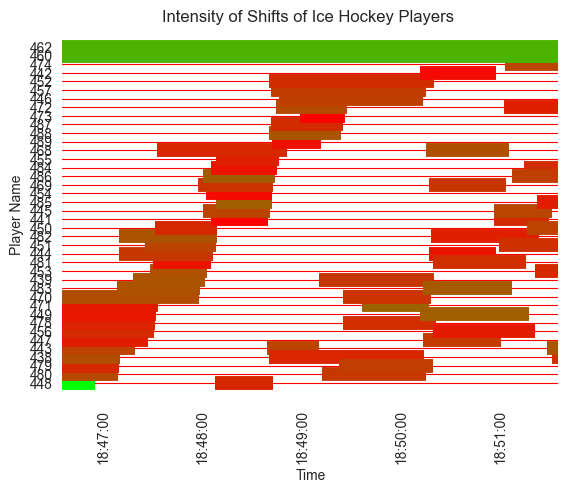

,timestamp,time,Timestamp (ms),Duration (s),Name,Skating Intensity,relative_intensity
0,2022-12-10 18:46:35,0 days 00:00:20.010000,1670697995000,20,448,1,0
1,2022-12-10 18:46:35,0 days 00:00:33.499001,1670697995000,33,480,38,1
2,2022-12-10 18:46:35,0 days 00:00:33.981998,1670697995000,34,479,45,1
3,2022-12-10 18:46:35,0 days 00:00:34.707001,1670697995000,35,438,37,1
4,2022-12-10 18:46:35,0 days 00:00:43.952999,1670697995000,44,443,39,1
...,...,...,...,...,...,...,...
64,2022-12-10 18:51:16,0 days 00:01:10.347000,1670698276000,70,450,39,1
65,2022-12-10 18:51:21,0 days 00:01:05.619003,1670698281000,66,453,45,1
66,2022-12-10 18:51:28,0 days 00:01:04.376999,1670698288000,64,443,36,1
233,2022-12-10 18:46:35,0 days 00:20:00.186035,1670697995000,1200,460,17,0


In [51]:
block_config = None

utils.plot_shifts_with_intensity(df_no_keepers, block_config=block_config)

## 2.2 Intensities for Blocks using elbow-method

Here we see, that there is at least 1 block with too many players.

ELBOW METHOD


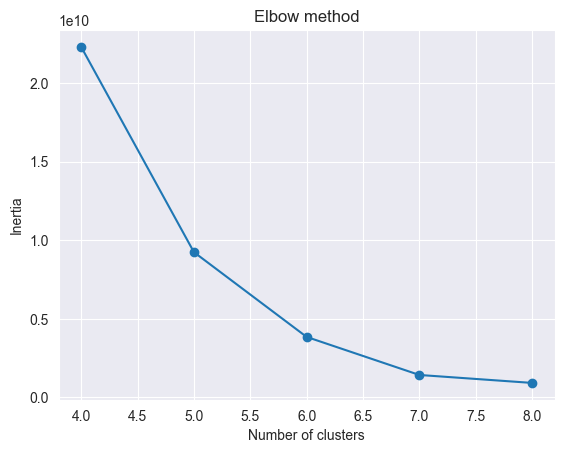

Knee, i.e. calculated number of shifts, is at: 6
Summary of all Shifts. Points are the individual players. Colors are their blocks.


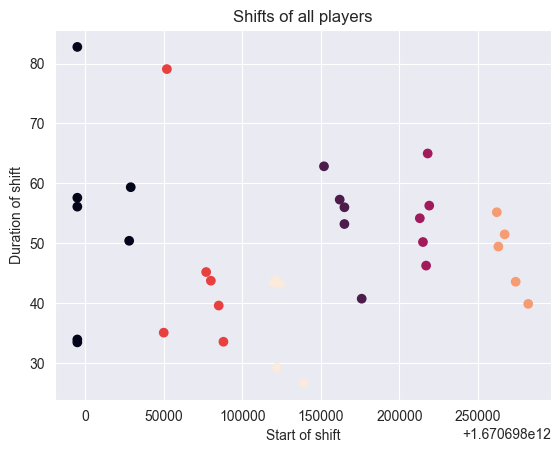

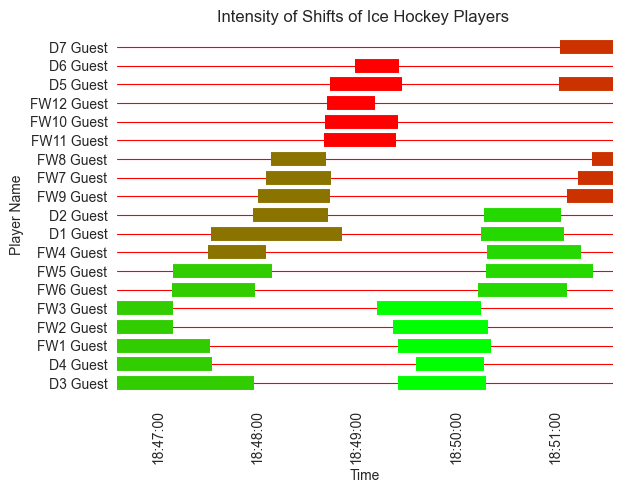

,timestamp,time,Timestamp (ms),Duration (s),Name,Skating Intensity,Shift_Label,relative_intensity
4,2022-12-10 18:46:35,0 days 00:01:22.765999,1670697995000,82.765999,D3 Guest,37.51,0,0.194940
7,2022-12-10 18:46:35,0 days 00:00:57.615002,1670697995000,57.615002,D4 Guest,48.18,0,0.194940
18,2022-12-10 18:46:35,0 days 00:00:56.131001,1670697995000,56.131001,FW1 Guest,46.07,0,0.194940
19,2022-12-10 18:46:35,0 days 00:00:33.981998,1670697995000,33.981998,FW2 Guest,45.19,0,0.194940
21,2022-12-10 18:46:35,0 days 00:00:33.499001,1670697995000,33.499001,FW3 Guest,38.47,0,0.194940
155,2022-12-10 18:47:08,0 days 00:00:50.438999,1670698028000,50.438999,FW6 Guest,36.44,0,0.194940
159,2022-12-10 18:47:09,0 days 00:00:59.375000,1670698029000,59.375000,FW5 Guest,36.21,0,0.194940
242,2022-12-10 18:47:30,0 days 00:00:35.120998,1670698050000,35.120998,FW4 Guest,49.45,3,0.545486
250,2022-12-10 18:47:32,0 days 00:01:19.073997,1670698052000,79.073997,D1 Guest,45.10,3,0.545486
370,2022-12-10 18:47:57,0 days 00:00:45.229000,1670698077000,45.229000,D2 Guest,42.73,3,0.545486


In [11]:
block_config = {
    "naive_number_of_shifts" : False,
    "verbose": True
}

utils.plot_shifts_with_intensity(df_no_keepers, block_config=block_config)

## 2.3 Intensities for Blocks using naive approach

The shifts make sense, even though there is an overlap for player D1 Guest.

NAIVE METHOD
Number of rows in dataset = 69
Probable number of shifts = 14
Summary of all Shifts. Points are the individual players. Colors are their blocks.


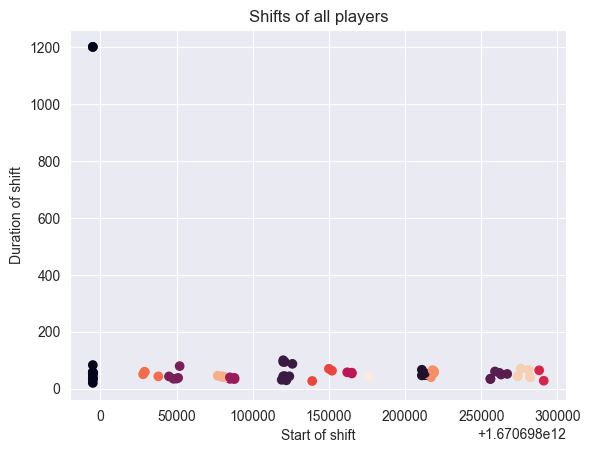

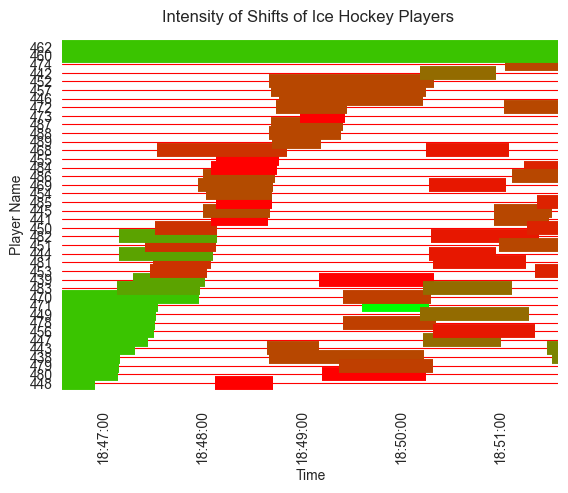

,timestamp,time,Timestamp (ms),Duration (s),Name,Skating Intensity,Shift_Label,relative_intensity
0,2022-12-10 18:46:35,0 days 00:00:20.010000,1670697995000,20,448,1,0,0
1,2022-12-10 18:46:35,0 days 00:00:33.499001,1670697995000,33,480,38,0,0
2,2022-12-10 18:46:35,0 days 00:00:33.981998,1670697995000,34,479,45,0,0
3,2022-12-10 18:46:35,0 days 00:00:34.707001,1670697995000,35,438,37,0,0
4,2022-12-10 18:46:35,0 days 00:00:43.952999,1670697995000,44,443,39,0,0
...,...,...,...,...,...,...,...,...
64,2022-12-10 18:51:16,0 days 00:01:10.347000,1670698276000,70,450,39,12,1
65,2022-12-10 18:51:21,0 days 00:01:05.619003,1670698281000,66,453,45,12,1
66,2022-12-10 18:51:28,0 days 00:01:04.376999,1670698288000,64,443,36,7,0
233,2022-12-10 18:46:35,0 days 00:20:00.186035,1670697995000,1200,460,17,0,0


In [52]:
block_config = {
    "naive_number_of_shifts" : True,
    "verbose": True
}

utils.plot_shifts_with_intensity(df_no_keepers, block_config=block_config)